In [1]:
import torch
import numpy as np
import os, sys, json, cv2, random
from glob import glob

from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg

base_path = '.'

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
register_coco_instances("my_dataset_train", {}, f'{base_path}/annotations/COCO/train.json', f'{base_path}/dataset/images/')
register_coco_instances("my_dataset_val", {}, f'{base_path}/annotations/COCO/val.json', f'{base_path}/dataset/images/')

In [3]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

In [4]:
num_train_samples=len(train_dataset_dicts)
num_val_samples=len(val_dataset_dicts)

In [64]:
batch_size = 4
num_iter = num_train_samples//batch_size

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.OUTPUT_DIR = './Saved Models/Detectron2_models/'
cfg.DATASETS.TRAIN = ("my_dataset_train")
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.INPUT.MIN_SIZE = 640
cfg.INPUT.MIN_SIZE_TRAIN = 640
cfg.INPUT.MIN_SIZE_TEST = 640
cfg.INPUT.MAX_SIZE = 640
cfg.INPUT.MAX_SIZE_TRAIN = 640
cfg.INPUT.MAX_SIZE_TEST = 640
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 300*num_iter   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg)
#trainer.resume_or_load(resume=False)


In [65]:
from detectron2.evaluation import COCOEvaluator
from detectron2.engine.hooks import HookBase
from detectron2.data import build_detection_test_loader
from collections import deque

import logging
logging.getLogger("detectron2").setLevel(logging.INFO)

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

class EarlyStoppingHook(HookBase):
    def __init__(self, trainer, eval_period, max_iter):
        self.trainer = trainer
        self._period = eval_period
        self._max_iter = max_iter
        self.last_AP = []

    def _do_eval(self):
        result = self.trainer.test(self.trainer.cfg, self.trainer.model)['bbox']['AP']
        if not np.isnan(result):    
            if len(self.last_AP)>=10:
                if np.argmax(self.last_AP)==0 and result < self.last_AP[0]:
                    raise Exception("Stopping early")
                self.last_AP[:9] = self.last_AP[1:]  
                self.last_AP[-1] = result
            else:
                self.last_AP.append(result)
            print(self.last_AP)
        

    def after_step(self):
        next_iter = self.trainer.iter + 1
        if next_iter % self._period == 0 or next_iter >= self._max_iter:
            self._do_eval()

trainer = MyTrainer(cfg)
trainer.register_hooks([EarlyStoppingHook(trainer, eval_period=num_iter, max_iter=cfg.SOLVER.MAX_ITER)])
trainer.resume_or_load(resume=False)
device = torch.device('cuda:0')
trainer.model.to(device)
trainer.train()

[01/11 11:04:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[01/11 11:04:37 d2.engine.train_loop]: Starting training from iteration 0
[01/11 11:04:44 d2.utils.events]:  eta: 1 day, 7:01:44  iter: 19  total_loss: 1.71  loss_cls: 1.512  loss_box_reg: 0.04189  loss_rpn_cls: 0.1446  loss_rpn_loc: 0.01067    time: 0.3552  last_time: 0.5414  data_time: 0.2788  last_data_time: 0.4566   lr: 9.9905e-06  max_mem: 9322M
[01/11 11:04:51 d2.utils.events]:  eta: 1 day, 6:19:31  iter: 39  total_loss: 1.314  loss_cls: 1.124  loss_box_reg: 0.04753  loss_rpn_cls: 0.08686  loss_rpn_loc: 0.009117    time: 0.3391  last_time: 0.0905  data_time: 0.2447  last_data_time: 0.0118   lr: 1.998e-05  max_mem: 9322M
[01/11 11:04:58 d2.utils.events]:  eta: 1 day, 7:03:42  iter: 59  total_loss: 0.8406  loss_cls: 0.6195  loss_box_reg: 0.06073  loss_rpn_cls: 0.07557  loss_rpn_loc: 0.009925    time: 0.3495  last_time: 0.3748  data_time: 0.2879  last_data_time: 0.2948   lr: 2.9971e-05  max_mem: 9322M
[01/11 11:05:04 d2.utils.events]:  eta: 1 day, 7:03:36  iter: 79  total_loss: 0.45

Exception: Stopping early

In [66]:
result = trainer.test(trainer.cfg, trainer.model)

[01/11 14:21:04 d2.data.datasets.coco]: Loaded 877 images in COCO format from ./annotations/COCO/val.json
[01/11 14:21:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[01/11 14:21:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/11 14:21:04 d2.data.common]: Serializing 877 elements to byte tensors and concatenating them all ...
[01/11 14:21:04 d2.data.common]: Serialized dataset takes 0.24 MiB
WARNING [01/11 14:21:04 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/11 14:21:04 d2.evaluation.evaluator]: Start inference on 877 batches
[01/11 14:21:07 d2.evaluation.evaluator]: Inference done 11/877. Dataloading: 0.1833 s/iter. Inference: 0.0236 s/iter. Eval: 0.0002 s/iter. Total: 0.2071 s/iter. ETA=0:02:59
[01/11 14

In [69]:
trainer._hooks[-1].last_AP

[86.64823979538556,
 85.47829229067035,
 85.8322365612185,
 85.79443812388861,
 86.18692654066722,
 85.4138207116301,
 85.24679310136793,
 84.88083177653544,
 86.06064880195612,
 85.9695353611497]

In [20]:
sys.path.append('./src')
from bounding_box import BoundingBox
from evaluators import coco_evaluator, pascal_voc_evaluator
from utils.enumerators import BBFormat, BBType, CoordinatesType
from utils.enumerators import BBFormat, CoordinatesType,  MethodAveragePrecision
import matplotlib.pyplot as plt


In [7]:
from tqdm import tqdm
sys.path.append('./algorithms/') 
from detectron2_detector import Detectron2_detector

fasterRCNN_detector = Detectron2_detector("./Saved Models/Detectron2_models/mode_test.pth")
longest_edge_resize = 640

with open('./annotations/COCO/val.json') as json_file:
    coco_annotations = json.load(json_file)

with open('./annotations/COCO/datasets_info.json') as json_file:
    datasets_info = json.load(json_file)

VIA_datasets = {}
for dataset_name in datasets_info['datasets']:
    with open(datasets_info['datasets'][dataset_name]) as json_file:
        data = json.load(json_file)['_via_img_metadata']
        VIA_datasets[dataset_name] = {value['filename']:value for _, value in data.items()}


ann_index = 0
image_counter = 0
detected_bbs = []
groundtruth_bbs = []

for image_annotation in tqdm(coco_annotations['images']):
    id = image_annotation['id']
    file_name = image_annotation['file_name']
    true_boxes = []
    true_classes = []
    true_polygons = []
    remove_this_image = False
    while coco_annotations['annotations'][ann_index]['image_id'] == id:
        true_boxes.append(np.array(coco_annotations['annotations'][ann_index]['bbox']))
        true_classes.append(coco_annotations['annotations'][ann_index]['category_id']-1)
        true_polygons.append(np.array(coco_annotations['annotations'][ann_index]['segmentation']).reshape(4,2))
        
        ann_index+=1
        if ann_index >= len(coco_annotations['annotations']):
            break

    
    img_path = datasets_info['images'][file_name]['path']
    img = cv2.imread(img_path)
    image_counter+=1
    H,W,_ = img.shape
    if W > H:
        W_new = longest_edge_resize
        H_new = int(np.round((H*W_new)/W))
    else:
        H_new = longest_edge_resize
        W_new = int(np.round((W*H_new)/H))



    for i in range(len(true_boxes)):
        true_boxes[i][0::2] = np.int32(np.round(W_new*true_boxes[i][0::2]/W))
        true_boxes[i][1::2] = np.int32(np.round(H_new*true_boxes[i][1::2]/H))
        true_polygons[i][:,0] = np.int32(np.round(W_new*true_polygons[i][:,0]/W))
        true_polygons[i][:,1] = np.int32(np.round(H_new*true_polygons[i][:,1]/H))

    img = cv2.resize(img, (W_new, H_new), cv2.INTER_CUBIC)
    dataset_name = datasets_info['images'][file_name]['dataset']
    boxes, classes, confidences =fasterRCNN_detector.detect(img)
    detected_bbs.extend([BoundingBox(file_name, 0 if classes[i] == '1D' else 1, boxes[i], img_size=(W_new, H_new), confidence=confidences[i], bb_type=BBType.DETECTED) for i in range(len(boxes))])
    groundtruth_bbs.extend([BoundingBox(file_name, true_classes[i], true_boxes[i], img_size=(W_new, H_new), confidence=1, bb_type=BBType.GROUND_TRUTH) for i in range(len(true_boxes))])
print(coco_evaluator.get_coco_summary(groundtruth_bbs, detected_bbs))

100%|██████████| 877/877 [00:36<00:00, 24.25it/s]


defaultdict(<function _group_detections.<locals>.<lambda> at 0x7f5ce042ac20>, {('EAN13_09_0019.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f5cf4124a00>], 'gt': [<bounding_box.BoundingBox object at 0x7f5cf4125fc0>]}, ('EAN13_09_0021.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f5cf41263e0>], 'gt': [<bounding_box.BoundingBox object at 0x7f5cf4124e50>]}, ('EAN13_09_0027.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f5cf41245e0>], 'gt': [<bounding_box.BoundingBox object at 0x7f5cf4124640>]}, ('EAN13_09_0041.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f5cf4125ba0>], 'gt': [<bounding_box.BoundingBox object at 0x7f5cf4124ee0>]}, ('EAN13_09_0056.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f5cf4124a60>], 'gt': [<bounding_box.BoundingBox object at 0x7f5cf4124190>]}, ('EAN13_09_0059.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f5cf4125720>], 'gt': [<bounding_box.BoundingBox object at 0x7f5cf41252a0>]}, ('EAN13_09_0065.jpg',

In [19]:
len(list(filter(lambda x: x.get_class_id() == 1, groundtruth_bbs)))

155

In [26]:
class_id = 0
result = coco_evaluator.get_coco_summary(list(filter(lambda x: x.get_class_id() == class_id, groundtruth_bbs)),
                                list(filter(lambda x: x.get_class_id() == class_id, detected_bbs)))

Ap0 = result['AP']
class_id = 1
result = coco_evaluator.get_coco_summary(list(filter(lambda x: x.get_class_id() == class_id, groundtruth_bbs)),
                                list(filter(lambda x: x.get_class_id() == class_id, detected_bbs)))

Ap1 = result['AP']
print(Ap0, Ap1, (Ap0+Ap1)/2)

defaultdict(<function _group_detections.<locals>.<lambda> at 0x7f3eac675bd0>, {('EAN13_09_0019.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f3eac103190>], 'gt': [<bounding_box.BoundingBox object at 0x7f3eac1035b0>]}, ('EAN13_09_0021.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f3eac102bc0>], 'gt': [<bounding_box.BoundingBox object at 0x7f3eac102f50>]}, ('EAN13_09_0027.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f3eac102a70>], 'gt': [<bounding_box.BoundingBox object at 0x7f3eac103250>]}, ('EAN13_09_0041.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f3eac1029b0>], 'gt': [<bounding_box.BoundingBox object at 0x7f3eac102fe0>]}, ('EAN13_09_0056.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f3eac1028f0>], 'gt': [<bounding_box.BoundingBox object at 0x7f3eac1034f0>]}, ('EAN13_09_0059.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f3eac102830>], 'gt': [<bounding_box.BoundingBox object at 0x7f3eac102cb0>]}, ('EAN13_09_0065.jpg',

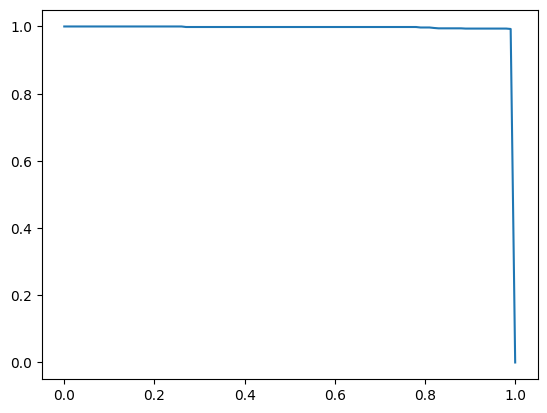

In [21]:
x = coco_evaluator.get_coco_metrics(groundtruth_bbs, detected_bbs)[0]['interpolated recall']
y = coco_evaluator.get_coco_metrics(groundtruth_bbs, detected_bbs)[0]['interpolated precision']
plt.plot(x,y)

In [14]:
coco_evaluator.get_coco_summary(groundtruth_bbs, detected_bbs)

defaultdict(<function _group_detections.<locals>.<lambda> at 0x7f2de1b73880>, {('EAN13_09_0019.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f2de162ca60>], 'gt': [<bounding_box.BoundingBox object at 0x7f2de162f010>]}, ('EAN13_09_0021.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f2de162c040>], 'gt': [<bounding_box.BoundingBox object at 0x7f2de162e470>]}, ('EAN13_09_0027.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f2de162fcd0>], 'gt': [<bounding_box.BoundingBox object at 0x7f2de162c520>]}, ('EAN13_09_0041.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f2de162e560>], 'gt': [<bounding_box.BoundingBox object at 0x7f2de162f070>]}, ('EAN13_09_0056.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f2de162fdc0>], 'gt': [<bounding_box.BoundingBox object at 0x7f2de162dc60>]}, ('EAN13_09_0059.jpg', 0): {'dt': [<bounding_box.BoundingBox object at 0x7f2de162e5c0>], 'gt': [<bounding_box.BoundingBox object at 0x7f2de162fa90>]}, ('EAN13_09_0065.jpg',

{'AP': 0.8483252913581127,
 'AP50': 0.9669049786298529,
 'AP75': 0.9542496444687845,
 'TP50': 951,
 'FP50': 22,
 'FN50': 14,
 'TP75': 937,
 'FP75': 36,
 'FN75': 28,
 'P': 965,
 'APsmall': 0.5544126335710495,
 'APmedium': 0.7909604183610695,
 'APlarge': 0.9160566613894219,
 'AR1': 0.8269195539625646,
 'AR10': 0.8899900438072482,
 'AR100': 0.8899900438072482,
 'ARsmall': 0.5857575757575757,
 'ARmedium': 0.837703677839851,
 'ARlarge': 0.9480298913043479}

In [7]:
pascal_voc_evaluator.get_pascalvoc_metrics(groundtruth_bbs,
                          detected_bbs,
                          iou_threshold=0.5,
                          method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                          generate_table=False)

UnboundLocalError: local variable 'ap' referenced before assignment

In [70]:
torch.save(trainer.model, "./Saved Models/Detectron2_models/model_final.pth")

In [71]:
model = torch.load("./Saved Models/Detectron2_models/model_final.pth")
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [8]:
#cfg = get_cfg()
cfg.MODEL.WEIGHTS = "./Saved Models/Detectron2_models/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.DATASETS.TEST = ("my_dataset_val")
predictor = DefaultPredictor(cfg)
model = build_model(cfg)

[01/10 14:56:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Saved Models/Detectron2_models/model_final.pth ...


In [11]:
img_paths = glob('./dataset/images/*.jpg')
longest_edge_resize = 640

In [20]:
img = cv2.imread(img_paths[0])
H,W,_ = img.shape
if W > H:
    W_new = longest_edge_resize
    H_new = int(np.round((H*W_new)/W))
else:
    H_new = longest_edge_resize
    W_new = int(np.round((W*H_new)/H))

img = cv2.resize(img, (W_new, H_new), cv2.INTER_CUBIC)

input = [{'image':torch.from_numpy(np.transpose(img, (2, 0, 1))), 
         'height':H_new, 
         'width':W_new}]

result = model(input)

In [21]:
result_dictionary = result[0]['instances'].get_fields()

In [22]:
result_dictionary['pred_boxes'].tensor.cpu().detach().numpy()

array([[155.01411, 368.0498 , 337.13727, 405.69452]], dtype=float32)

In [25]:
result_dictionary['scores'].cpu().detach().numpy()

array([0.9686272], dtype=float32)

In [24]:
result_dictionary['pred_classes'].cpu().detach().numpy()


array([0])

In [8]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
import random
import time
counter = 0
predictor = DefaultPredictor(trainer)

for d in val_dataset_dicts:   
    if np.random.uniform(0,1) > 0.03:
        continue 
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=val_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[::2, ::2, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    counter+=1
    if counter> 100:
        break

AttributeError: 'MyTrainer' object has no attribute 'clone'

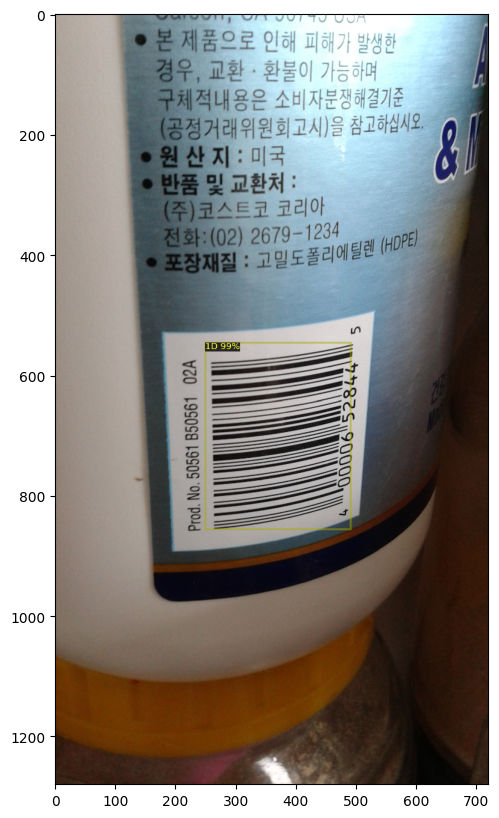

In [15]:
im = cv2.imread(d["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=val_metadata)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[::2, ::2, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
instances = outputs["instances"]
detected_class_indexes = instances.pred_classes
prediction_boxes = instances.pred_boxes

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
#class_catalog = metadata.thing_classes

#for idx, coordinates in enumerate(prediction_boxes):
#    class_index = detected_class_indexes[idx]
#    class_name = class_catalog[class_index]
#    print(class_name, coordinates)

print(prediction_boxes, detected_class_indexes, metadata)

Boxes(tensor([[ 497.8203, 1092.0125,  980.0560, 1712.1021]], device='cuda:2')) tensor([0], device='cuda:2') Metadata(name='m')
